In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("China Financial Statement Analysis and Anomaly Detection Dataset (CFSAAD 2021 2025).csv")

In [3]:
df.head()

,company_id,company_name,year,industry,region,revenue,net_profit,total_assets,total_liabilities,equity,...,audit_opinion,fraud_risk_score,g_index,esg_score,stock_volatility,market_cap,ownership_type,risk_category,audit_firm,financial_health_index
0,SH969694,Haier Precision Ltd.,2022,Manufacturing,Sichuan,10842.32,1941.90,16828.60,6075.45,10753.15,...,Qualified,0.37,1,61,0.18,32356.57,Private,Low,Big4,0.15
1,SH319685,Guangzhou Pharma Group,2022,Pharmaceuticals,Hebei,10645.28,522.59,15085.21,10776.40,4308.81,...,Standard,0.18,2,61,0.33,28095.09,Private,Low,Local Tier 1,0.08
2,SZ694732,Sinopec Green Energy,2022,Energy,Sichuan,8993.79,2226.45,13173.37,4370.65,8802.72,...,Standard,0.74,8,63,0.36,21973.57,Private,High,Local Tier 2,0.21
3,SZ358608,Guangzhou Pharma Group,2022,Pharmaceuticals,Hebei,5305.38,1238.70,8370.68,3011.75,5358.93,...,Standard,0.56,10,42,0.57,11651.27,SOE,Medium,Local Tier 1,0.19
4,SZ245052,CRRC Urban Transit,2021,Transportation,Jiangsu,9084.19,2759.81,16503.92,9025.96,7477.96,...,Standard,0.42,2,57,0.25,28162.58,Private,Medium,Local Tier 1,0.27


In [4]:
df.shape

(37325, 27)

In [5]:
### check duplicate
df.duplicated().sum()

0

In [6]:
### check whether missing value
df.isnull().sum()

company_id                0
company_name              0
year                      0
industry                  0
region                    0
revenue                   0
net_profit                0
total_assets              0
total_liabilities         0
equity                    0
operating_cash_flow       0
roe                       0
roa                       0
debt_to_equity_ratio      0
profit_margin             0
anomaly_label             0
credit_rating             0
audit_opinion             0
fraud_risk_score          0
g_index                   0
esg_score                 0
stock_volatility          0
market_cap                0
ownership_type            0
risk_category             0
audit_firm                0
financial_health_index    0
dtype: int64

In [7]:
### check outliers 
numeric = ["revenue","net_profit","total_assets","total_liabilities","equity",
    "operating_cash_flow","roe","roa","debt_to_equity_ratio","profit_margin",
    "fraud_risk_score","g_index","esg_score","stock_volatility","market_cap",
    "financial_health_index"]

df_check = df[numeric]

z_scores = np.abs(stats.zscore(df_check))
outliers_z = (z_scores > 3).sum(axis=0)
print(outliers_z)

revenue                    68
net_profit                302
total_assets              152
total_liabilities         284
equity                    312
operating_cash_flow       321
roe                       481
roa                       210
debt_to_equity_ratio      261
profit_margin             152
fraud_risk_score            0
g_index                     0
esg_score                   0
stock_volatility          126
market_cap                239
financial_health_index    367
dtype: int64


In [8]:
### Pipline to handle the outliers. I use the mean that exclude the outliers to replace the outliers.
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.clean_means_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        if self.cols is None:
            self.cols = X.select_dtypes(include=[np.number]).columns
        
        for col in self.cols:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR

            clean_vals = X.loc[(X[col] >= lower) & (X[col] <= upper), col]
            self.clean_means_[col] = clean_vals.mean()
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.cols:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR

            X.loc[(X[col] < lower) | (X[col] > upper), col] = self.clean_means_[col]
        return X

pipeline = Pipeline([
    ("outlier_handler", OutlierHandler(cols=numeric))
])

df_clean = pipeline.fit_transform(df)

In [9]:
### But there still are some outliers. There are 37325 rows. Only 20 outilers. 
### I just ignore these twenty outilers.
### And I will not use debt_to_equity_ratio to do the K-means cluster. I will choose some variables that 
### are representative and contains enough informations. 
z_scores_clean = np.abs(stats.zscore(df_clean[numeric]))
outliers_z_clean = (z_scores_clean > 3).sum(axis=0)
print(outliers_z_clean)

revenue                    0
net_profit                 0
total_assets               0
total_liabilities          0
equity                     0
operating_cash_flow        0
roe                        0
roa                        0
debt_to_equity_ratio      20
profit_margin              0
fraud_risk_score           0
g_index                    0
esg_score                  0
stock_volatility           0
market_cap                 0
financial_health_index     0
dtype: int64


In [10]:
df_clean.head()

,company_id,company_name,year,industry,region,revenue,net_profit,total_assets,total_liabilities,equity,...,audit_opinion,fraud_risk_score,g_index,esg_score,stock_volatility,market_cap,ownership_type,risk_category,audit_firm,financial_health_index
0,SH969694,Haier Precision Ltd.,2022,Manufacturing,Sichuan,10842.32,1941.90,16828.60,6075.45,10753.15,...,Qualified,0.37,1.0,61.0,0.18,32356.57,Private,Low,Big4,0.15
1,SH319685,Guangzhou Pharma Group,2022,Pharmaceuticals,Hebei,10645.28,522.59,15085.21,10776.40,4308.81,...,Standard,0.18,2.0,61.0,0.33,28095.09,Private,Low,Local Tier 1,0.08
2,SZ694732,Sinopec Green Energy,2022,Energy,Sichuan,8993.79,2226.45,13173.37,4370.65,8802.72,...,Standard,0.74,8.0,63.0,0.36,21973.57,Private,High,Local Tier 2,0.21
3,SZ358608,Guangzhou Pharma Group,2022,Pharmaceuticals,Hebei,5305.38,1238.70,8370.68,3011.75,5358.93,...,Standard,0.56,10.0,42.0,0.57,11651.27,SOE,Medium,Local Tier 1,0.19
4,SZ245052,CRRC Urban Transit,2021,Transportation,Jiangsu,9084.19,2759.81,16503.92,9025.96,7477.96,...,Standard,0.42,2.0,57.0,0.25,28162.58,Private,Medium,Local Tier 1,0.27


In [11]:
#df_clean[["net_profit", "roa", "financial_health_index", "market_cap"]]

print(df_clean["net_profit"].mean(), df_clean["roa"].mean(), df_clean["financial_health_index"].mean(), df_clean["market_cap"].mean(), df_clean["esg_score"].mean(), df_clean["g_index"].mean())

1378.843988881925 10.385209160637546 0.16979503480024113 21869.270005433307 62.84214333556597 5.494735432016075


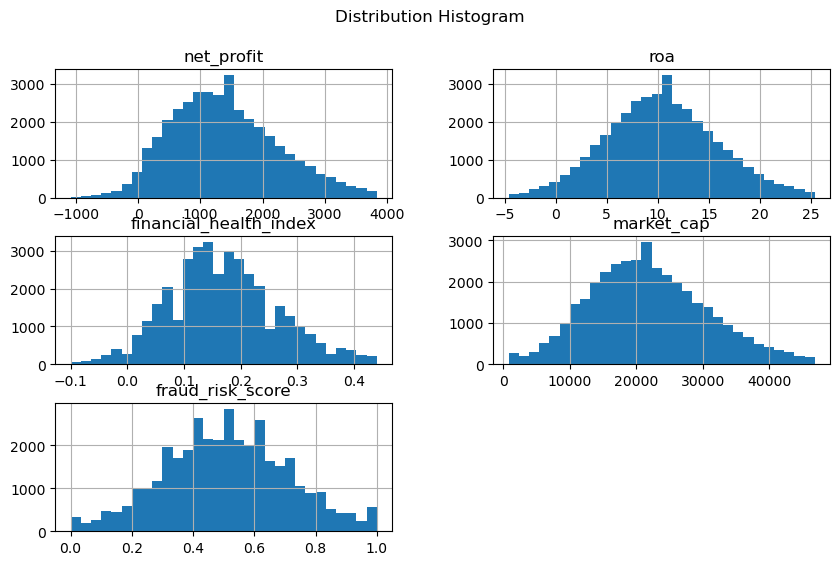

In [12]:
df_check_distribution = df_clean[["net_profit", "roa", "financial_health_index", "market_cap", "fraud_risk_score"]]

df_check_distribution.hist(bins=30, figsize=(10,6))
plt.suptitle("Distribution Histogram")
plt.show()

In [13]:
### After pre-processing the data, we turn to the K-Means cluster.
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# first, do the standardliztaion to the factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[["net_profit", "roa", "financial_health_index", "market_cap", "fraud_risk_score"]])

# giving k a range, find the best k in that range
inertia = []
silhouette = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # SSE
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

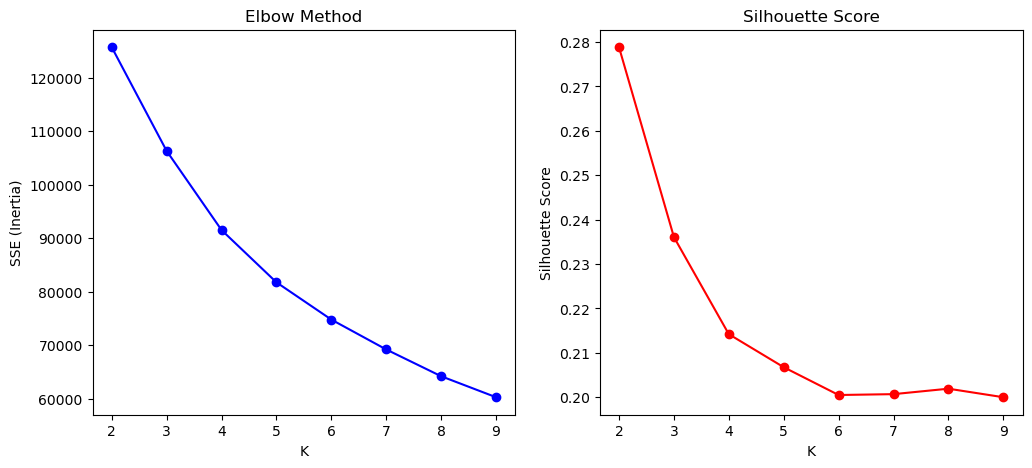

In [14]:
plt.figure(figsize=(12,5))

# Elbow Method
# As the number of clusters k increases, SSE will monotonically decrease.
# However, when k exceeds a certain point, the decline in SSE will significantly slow down - at this point, 
# continuing to increase the number of clusters will not bring much benefit.
plt.subplot(1,2,1)
plt.plot(K, inertia, 'bo-')
plt.xlabel("K")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method")

# Silhouette Coefficient
# The closer it is to 1, the better the clustering effect at this point is (tight and separated from other clusters).
plt.subplot(1,2,2)
plt.plot(K, silhouette, 'ro-')
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")

plt.show()

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[["net_profit", "roa", "financial_health_index", "market_cap"]])

# giving k a range, find the best k in that range
inertia = []
silhouette = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # SSE
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

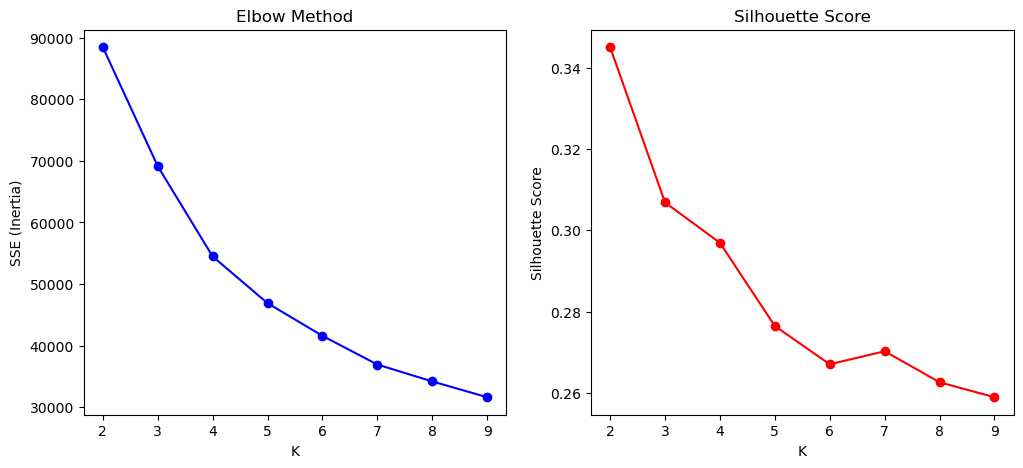

In [16]:
plt.figure(figsize=(12,5))

# Elbow Method
# As the number of clusters k increases, SSE will monotonically decrease.
# However, when k exceeds a certain point, the decline in SSE will significantly slow down - at this point, 
# continuing to increase the number of clusters will not bring much benefit.
plt.subplot(1,2,1)
plt.plot(K, inertia, 'bo-')
plt.xlabel("K")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method")

# Silhouette Coefficient
# The closer it is to 1, the better the clustering effect at this point is (tight and separated from other clusters).
plt.subplot(1,2,2)
plt.plot(K, silhouette, 'ro-')
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")

plt.show()

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[["net_profit", "financial_health_index", "market_cap"]])

# giving k a range, find the best k in that range
inertia = []
silhouette = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # SSE
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

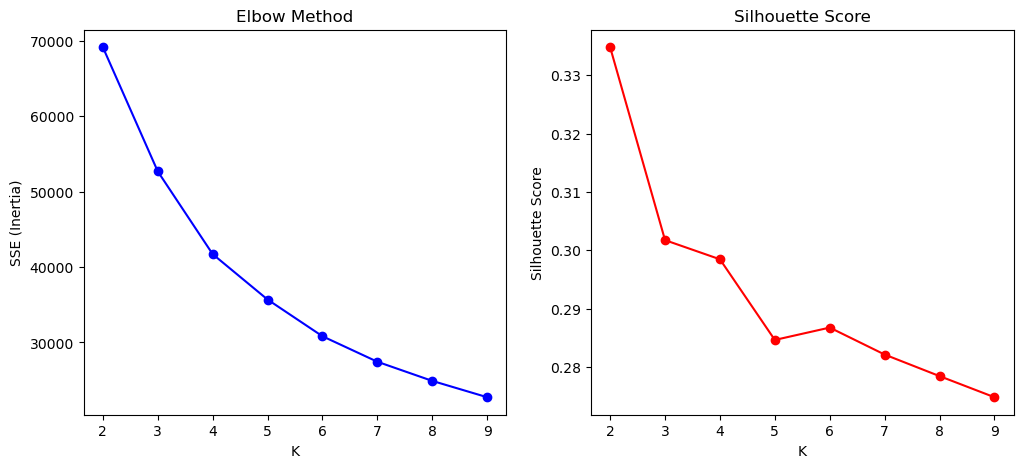

In [18]:
plt.figure(figsize=(12,5))

# Elbow Method
# As the number of clusters k increases, SSE will monotonically decrease.
# However, when k exceeds a certain point, the decline in SSE will significantly slow down - at this point, 
# continuing to increase the number of clusters will not bring much benefit.
plt.subplot(1,2,1)
plt.plot(K, inertia, 'bo-')
plt.xlabel("K")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method")

# Silhouette Coefficient
# The closer it is to 1, the better the clustering effect at this point is (tight and separated from other clusters).
plt.subplot(1,2,2)
plt.plot(K, silhouette, 'ro-')
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")

plt.show()

In [ ]:
# So the first one cluster, I add fraud_risk_score this factor. And for the second one I delete the fraud_risk_score. We can find that without fraud_risk_score
# have a better score and effect. So I drop the fraud_risk_score.
# And according to the results, I choose K=3 to do the cluster.
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

print("\nThe number of companies in each cluster:") # It indicates that there are three relatively stable groups of companies in the market.
print(df["cluster"].value_counts()) 

print("\nThe financial mean of each cluster:") 
# Cluster 0 - Financially Disadvantaged Group. A typical "small-scale, low-profit" company
# Cluster 1 - Large Robust Group. A "big and comprehensive" company has strong profitability and a large market scale, but its efficiency may not be the highest.
# Cluster 2 - High Efficiency Group. A company with excellent financial efficiency, but its overall scale is not as large as that of Cluster 1.
print(df.groupby("cluster")[["net_profit", "roa", "financial_health_index", "market_cap"]].mean())

print("\nThe average ESG values of each cluster:")
# It indicates that there is a certain correlation between financial performance and ESG, but it is not a completely linear relationship.

# Large companies (Cluster 1) have an advantage in ESG because they are subject to more regulation, public supervision, 
# and have more resources allocated to governance, environmental protection, and social responsibility.

# High-efficiency companies (Cluster 2) do not necessarily have higher ESG performance. 
# This might be because ESG investment requires additional costs. These companies place more emphasis on short-term efficiency, while ESG improvement often requires long-term investment.

# Small companies (Cluster 0) have weak performance in both finance and ESG, and may lack the resources and capabilities to improve ESG.
print(df.groupby("cluster")[["esg_score", "g_index"]].mean())
print(df.groupby("cluster")[["esg_score", "g_index"]].median())



The number of companies in each cluster:
cluster
0    14881
2    11803
1    10641
Name: count, dtype: int64

The financial mean of each cluster:
          net_profit        roa  financial_health_index    market_cap
cluster                                                              
0         620.545404   5.509706                0.088817  19261.404714
1        2091.448999  11.050723                0.181112  31692.013037
2        1826.703269  16.131059                0.279519  17612.920107

The average ESG values of each cluster:
         esg_score   g_index
cluster                     
0        62.389490  5.478261
1        63.368856  5.494033
2        62.937982  5.516140


##### Large companies (Cluster 1) → Financially stable → Have slightly higher ESG scores due to regulatory and resource advantages.
##### Efficient companies (Cluster 2) → High ROA, but slightly lower ESG scores, indicating that "high efficiency ≠ high sustainability".
##### Small companies (Cluster 0) → Weak financial performance, no ESG advantages, possibly in a passive state.

##### Cluster 0 → "Small scale + Financially weak + ESG average"
##### Cluster 1 → "Large company + Financially stable + ESG high"
##### Cluster 2 → "High efficiency + Financially healthy + ESG slightly weak"

# The impact of financial performance on ESG scores is not "the higher, the better", but rather it is manifested as "large companies being more outstanding in ESG, while high-efficiency companies may be weaker in ESG".

##### The impact of financial performance on ESG is indirect: robust financial performance of large companies → higher ESG; however, highly efficient companies do not necessarily correspond to high ESG.

##### The scale effect is significant: Companies with large market capitalization and high net profit tend to have better ESG scores, indicating that resources and external pressures have driven the improvement in ESG performance.

##### The tension between efficiency and sustainability: Enterprises with high ROA have relatively lower ESG scores, suggesting to investors and policymakers: Companies that pursue high efficiency may neglect ESG, and this poses risks.

### Conclusion
##### Investment Insights:
##### For Investors: → Prioritize companies with strong financial stability and high ESG ratings (Cluster 1).
##### For Regulators: → Need to strengthen ESG supervision of high-efficiency companies (Cluster 2).
##### For Small Companies (Cluster 0): → Policies may be needed to enhance their ESG performance.
